# MNIST Lab

## MNIST reference:

- http://yann.lecun.com/exdb/mnist/

## PyTorch reference:

- https://pytorch.org/docs/stable/index.html


In [1]:
# read the csv file (i.e., ./data/mnist.csv) with pandas
# store data into numpy arrays

import numpy as np
import pandas as pd

%time data = list(pd.read_csv("./data/mnist_train.csv", header=None).values)
data = np.array(data)

img = data[:, 1:].reshape((-1, 28, 28)) # (-1, 28, 28):指定后两维大小为28 * 28， 第0维大小自动计算
lab = data[:, 0]
one = np.zeros((len(lab), 10))
one[range(len(lab)), lab] = 1
data = None

batch_size, learning_rate, epochs = 200, 0.1, 20

CPU times: total: 1.78 s
Wall time: 1.93 s


In [2]:
# check loaded data by showing some key properties of the numpy arrays

print(img.shape, lab.shape, np.mean(one, axis=0))

(60000, 28, 28) (60000,) [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751667 0.09915   ]


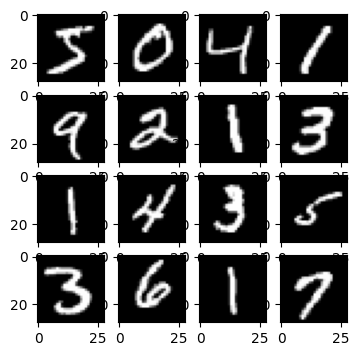

In [3]:
# check loaded data by showing a few images

import matplotlib.pyplot as plt
%matplotlib inline

size = 4
plt.figure(figsize=(size, size))
for i in range(size*size):
  plt.subplot(size, size, i+1)
  plt.imshow(img[i], cmap='gray')

In [4]:
# check loaded data by showing a few labels

print(lab[:size*size])
print(one[:size*size])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [5]:
# split the dataset into training and validation datasets
from sklearn.model_selection import train_test_split

img = img / 256

img_train, img_test, lab_train, lab_test, one_train, one_test = train_test_split(img, lab, one, test_size=0.2, random_state=2020)
print(img_train.shape, img_test.shape)
print(lab_train.shape, lab_test.shape)
print(one_train.shape, one_test.shape)

(48000, 28, 28) (12000, 28, 28)
(48000,) (12000,)
(48000, 10) (12000, 10)


# Lab Requirements

Rewrite the following cells to train and to evaluate the same neural network without using any Deep Learning APIs. That means you can only use NumPy or Tensors, but you cannot use torch.nn or torch.optim.


In [6]:
import torch as pt
from tqdm.notebook import tqdm
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

# define a simple neural network model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense = nn.Sequential(nn.Flatten(),
                                   nn.Linear(28 * 28, 256), nn.ReLU(),
                                   nn.Linear(256, 256), nn.ReLU(),
                                   nn.Linear(256, 10))

    def forward(self, x):
        return self.dense(x)

# prepare the datasets for training
img_train = pt.from_numpy(img_train).float()
lab_train = pt.from_numpy(lab_train).long()
data_train = DataLoader(TensorDataset(img_train, lab_train), batch_size=batch_size, shuffle=True, drop_last=True)
# batch_size：一次读取几张； suffle：每轮读取是否打乱顺序； drop_last: 如果设置为True：这个是对最后的未完成的batch来说的，
# 比如你的batch_size设置为64，而一个epoch只有100个样本，那么训练的时候后面的36个就被扔掉了… 

img_test = pt.from_numpy(img_test).float()
lab_test = pt.from_numpy(lab_test).long()
data_test = DataLoader(TensorDataset(img_test, lab_test), batch_size=batch_size, shuffle=False, drop_last=True)

# train a simple neural network model
dev = pt.device('cpu')
model = MyModel().to(dev)
loss = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs): # epochs = 20
    running_loss = []
    for x, y in data_train:
        x = Variable(x).to(dev)
        y = Variable(y).to(dev)
        model.train()
        yy = model(x)

        l = loss(yy, y)
        opt.zero_grad()
        l.backward()
        opt.step()
        running_loss.append(float(l))

    running_acc = []
    for x, y in data_test:
        x = Variable(x).to(dev)
        y = Variable(y).to(dev)
        model.eval()
        yy = model(x)
        yy = pt.argmax(yy, dim=1)

        acc = float(pt.sum(yy == y)) / batch_size
        running_acc.append(acc)

    print("#summary:% 4d %.4f %.2f%%" % (epoch, np.mean(running_loss), np.mean(running_acc)*100))

#summary:   0 0.9516 88.30%
#summary:   1 0.3357 91.13%
#summary:   2 0.2687 92.75%
#summary:   3 0.2248 93.49%
#summary:   4 0.1927 94.42%
#summary:   5 0.1675 94.93%
#summary:   6 0.1467 95.45%
#summary:   7 0.1308 95.72%
#summary:   8 0.1170 96.08%
#summary:   9 0.1059 96.36%
#summary:  10 0.0956 96.53%
#summary:  11 0.0871 96.78%
#summary:  12 0.0799 96.94%
#summary:  13 0.0725 96.97%
#summary:  14 0.0670 97.23%
#summary:  15 0.0615 97.19%
#summary:  16 0.0562 97.36%
#summary:  17 0.0524 97.38%
#summary:  18 0.0485 97.47%
#summary:  19 0.0443 97.53%


In [ ]:
# rewrite the code to train and to evaluate the same neural network
# you can fill in the TODO part of the code below, or just delete it and write your own code from scratch

import os
import random
import numpy as np
from copy import deepcopy as dco


def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    pt.manual_seed(seed)
    pt.cuda.manual_seed(seed)
    pt.cuda.manual_seed_all(seed)
    pt.backends.cudnn.benchmark = False
    pt.backends.cudnn.deterministic = True


class Neural_Network:
    def __init__(self, dims, data_train, data_test, epoch, batch_size, l_rate):
        # initialization
        # variable definitions: x_2 = ReLU(z_2), z_2 = x_1w_1 + b_1
        set_seed(2023)
        self.w, self.b, self.x = [], [], []
        self.x.append(np.zeros([batch_size, dims[0]], 'float64'))  # 4 * (28 * 28)
        for i in range(1, len(dims)): # 初始化每一层的参数
            self.w.append(np.random.uniform(-0.1, 0.1, (dims[i-1], dims[i])))
            self.b.append(np.zeros(dims[i], 'float64'))
            self.x.append(np.zeros((batch_size, dims[i]), 'float64'))
        
        # define the parameters
        self.layer_num = len(dims) - 1
        self.data_train = data_train
        self.data_test = data_test
        self.epoch = epoch
        self.batch_size = batch_size
        self.l_rate = l_rate
        self.z = dco(self.x)
        self.grad_x, self.grad_w, self.grad_b = dco(self.x), dco(self.w), dco(self.b)
    
    # define the activation function
    def actFunciton(self, x):
        return np.maximum(x, 0)

    def actDerivation(self, x):
        # TODO: return the the derivative
        
        d_x = dco(x)
        d_x = np.maximum(0, d_x)
        d_x[d_x>0] = 1
        return d_x

    # define the forward function
    def forward(self):
        # update rule: x_2 = ReLU(z_2), z_2 = x_1w_1 + b_1
        # TODO: forward update z, x
        
#         self.x[1] = [(self.x[0] @ self.w[0][:, i:i+1]) for i in range(dim[1])] +  + self.b[0]
#         z_2 = [(self.x[1] @ self.w[1][:, i:i+1]) for i in range(dim[2])]  + self.b[1]
#         self.x[2] = self.actFunction(z_2)
#         self.x[3] = [(self.x[2] @ self.w[2][:, i:i+1])for i in range(dim[3])]  + self.b[2]

        for i in range(self.layer_num):
            self.z[i+1] = np.dot(self.x[i], self.w[i]) + self.b[i]
            self.x[i+1] = self.actFunciton(self.z[i+1])
        
        
    # define the loss function
    def loss(self, y_pred, y_real):
        # TODO: return the cross entropy loss
        
#         print(y_pred, y_real, len(y_real))
        # y_pred: 200 * 10的矩阵，每一行代表一个样本的预测向量； y_real: 1 * 200的向量，每一分量是对应样本的ground true
        
        self.y_real_matrix = np.zeros_like(y_pred)
        self.y_real_matrix[np.arange(len(y_real)), y_real] = 1
    
        temp = np.log(y_pred)
        where_inf = np.isinf(temp)  # 消除log(0) = -inf的情况
        temp[where_inf] = 0
        cross_entropy_loss = np.mean( -np.sum(self.y_real_matrix * temp, axis=1) )
        return cross_entropy_loss
    
    # define the backward function
    def backward(self, y_real):
        # TODO: backward update grad_x, grad_w, grad_b
        
        grad_x = [None] * self.layer_num
        grad_w = [None] * self.layer_num
        grad_b = [None] * self.layer_num

        # 误差
        delta = self.x[-1] - self.y_real_matrix

        # 输出层梯度
        grad_b[-1] = np.mean(delta, axis=0)
        grad_w[-1] = np.dot(self.x[-2].T, delta) / self.batch_size

        # backward计算其他层参数的梯度
        for l in range(2, self.layer_num+1):
            delta = np.dot(delta, self.w[-l+1].T) * self.actDerivation(self.z[-l])
            grad_b[-l] = np.mean(delta, axis=0)
            grad_w[-l] = np.dot(self.x[-l-1].T, delta) / self.batch_size

        # 更新
        self.grad_x = grad_x
        self.grad_w = grad_w
        self.grad_b = grad_b

            
    # define the update function
    def update(self):
        self.b = [self.b[i] - self.l_rate * self.grad_b[i] for i in range(self.layer_num)]
        self.w = [self.w[i] - self.l_rate * self.grad_w[i] for i in range(self.layer_num)]
    
    # train the neural network model
    def train(self):
        running_loss = []
        running_acc = []

        for epoch in range(self.epoch):
            for train_x, train_y in data_train: 
                train_x = train_x.numpy()
                train_y = train_y.numpy()
                self.x[0] = train_x.reshape((self.batch_size, -1))  # 原始输入
                self.forward() 
                batch_loss = self.loss(self.x[-1], train_y)
                self.backward(train_y)
                self.update()
                running_loss.append(batch_loss)

            for test_x, test_y in data_test:
                test_x = test_x.numpy()
                test_y = test_y.numpy()
                self.x[0] = test_x.reshape((self.batch_size, -1))
                self.forward()
                out = np.argmax(self.x[-1], axis=1) # 用于返回一个numpy数组中最大值的索引值。当一组中同时出现几个最大值时，返回第一个最大值的索引值。
                running_acc.append(np.mean(out == test_y))

            print("#summary:% 4d %.4f %.2f%%" % (epoch, np.mean(running_loss), np.mean(running_acc) * 100))

# train the network
NN = Neural_Network([28 * 28, 256, 256, 10], data_train, data_test, epochs, batch_size, learning_rate)
NN.train()

C:\Users\wrzha\AppData\Local\Temp\ipykernel_17644\2512965957.py:80: RuntimeWarning: divide by zero encountered in log
  temp = np.log(y_pred)


#summary:   0 0.5481 90.51%
#summary:   1 0.4236 91.65%
#summary:   2 0.3628 92.45%
#summary:   3 0.3250 93.02%
#summary:   4 0.2976 93.43%
#summary:   5 0.2766 93.77%
#summary:   6 0.2598 94.06%
#summary:   7 0.2458 94.30%
